### Modeling COCO - QA
* [Review](https://arxiv.org/abs/1610.01465)

In [1]:
%cd ..

/home/datascience/Data Fusion


### Setup Environment:

In [2]:
import os
import pandas as pd

from src.classifiers import preprocess_data, process_labels,split_data

from src.classifiers import VQADataset
from torch.utils.data import DataLoader

from src.classifiers import train_early_fusion, train_late_fusion

In [3]:
PATH = 'Embeddings/coco-qa/'
COLUMN = 'embeddings'

## Get data

In [9]:
df = pd.read_csv(os.path.join(PATH, 'embeddings.csv'))
df.head()

questions    answers  types  \
0            what is using umbrellas as a central theme  sculpture      0   
1            what does the piece of modern art comprise  umbrellas      0   
2       what is this sculpture using as a central theme  umbrellas      0   
3                    what is the color of the umbrellas      white      2   
4            what walks toward the rope perimeter fence   elephant      0   
...                                                 ...        ...    ...   
117679                    what is the color of the pipe     orange      2   
117680                   what is flying through the air        jet      0   
117681   what is carrying people across a forested area   elephant      0   
117682                 what serves as the train trestle     bridge      0   
117683               what is sleeping on the blue couch        cat      0   

        split    text_1    text_2    text_3    text_4    text_5    text_6  \
0       train  3.879250 -0.337302  2.728295 -0.177727 -0.734334 -0.124322   
1       train  3.165886 -1.776468  0.702027  1.142665 -1.085440  0.059205   
2       train  2.890666 -1.778237  3.530624 -0.772094 -0.794132 -0.311388   
3       train  1.495979 -2.096776 -0.237311  0.309544 -0.410521 -1.360798   
4       train  1.293394 -1.494146  0.500123 -0.098010 -0.942691 -2.122753   
...       ...       ...       ...       ...       ...       ...       ...   
117679   test -0.591110 -1.147144 -2.057630  0.873035  1.932623 -2.625315   
117680   test  1.801795 -2.007991  2.024034  0.150158  0.183692 -0.394541   
117681   test  2.705203 -1.650845  3.159321  0.202319  0.067193 -1.215160   
117682   test  2.689941 -2.478192  0.225150 -0.504555 -1.166819 -2.311880   
117683   test  3.501221 -1.203127  3.914156  1.794750 -1.006218 -2.402193   

        ...  image_758  image_759  image_760  image_761  image_762  image_763  \
0       ...  -0.291306  -0.262270  -0.227479  -1.403986   0.079803   0.147770   
1       ...  -0.291306  -0.262270  -0.227479  -1.403986   0.079803   0.147770   
2       ...  -0.291306  -0.262270  -0.227479  -1.403986   0.079803   0.147770   
3       ...  -0.291306  -0.262270  -0.227479  -1.403986   0.079803   0.147770   
4       ...  -3.133440   1.226790  -4.741875   1.580570   0.571090  -0.753970   
...     ...        ...        ...        ...        ...        ...        ...   
117679  ...  -0.742336  -2.671529  -0.506259  -0.022315   0.075383  -0.928526   
117680  ...   0.374013  -1.598445  -1.070093  -0.390244  -2.736878   0.653100   
117681  ...  -3.907779   1.252734  -2.616690   1.567708   1.269967   0.897443   
117682  ...   2.751901   0.495517   0.610449  -1.838627   2.053380  -2.348113   
117683  ...   0.022025   0.121051  -0.772872   1.831972   0.698990  -0.204354   

        image_764  image_765  image_766  image_767  
0       -1.023563   0.193850   0.246949  -2.262336  
1       -1.023563   0.193850   0.246949  -2.262336  
2       -1.023563   0.193850   0.246949  -2.262336  
3       -1.023563   0.193850   0.246949  -2.262336  
4       -0.807536   0.534862  -1.499307   1.479312  
...           ...        ...        ...        ...  
117679   1.678910   2.269851  -1.391023   3.745731  
117680   0.316393  -0.511265   2.508572   0.397601  
117681  -0.397553  -0.514117  -2.151052   1.392050  
117682  -0.578239  -0.785166   0.631083   0.337668  
117683   0.426761   0.239116   0.368592  -1.825998  

[117684 rows x 4868 columns]

## Data Perparation

In [7]:
# Split the data
train_df, test_df = split_data(df)

# Select features and labels vectors
text_columns = [column for column in df.columns if 'text' in column] #[f'text_{i}']
image_columns = [column for column in df.columns if 'image' in column] #[f'image_{i}']
label_columns = 'answers'


# Process and one-hot encode labels for training set
train_labels, mlb, train_columns = process_labels(train_df, col=label_columns)
test_labels = process_labels(test_df, col=label_columns, train_columns=train_columns)


train_dataset = VQADataset(train_df, text_columns, image_columns, label_columns, mlb, train_columns)
test_dataset = VQADataset(test_df, text_columns, image_columns, label_columns, mlb, train_columns)


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

Train Shape: (78736, 4868)
Test Shape: (38948, 4868)


### Models

In [8]:
text_input_size = len(text_columns)
image_input_size = len(image_columns)
output_size = len(mlb.classes_)
multilabel = False

Training Early Fusion Model:
The number of parameters of the model are: 678446
Epoch 1/10 - Test Accuracy: 0.5404
Epoch 1/10 - Training Time: 6.45 seconds | Inference Time: 3.28 seconds
Epoch 2/10 - Test Accuracy: 0.5638
Epoch 2/10 - Training Time: 6.12 seconds | Inference Time: 4.29 seconds
Epoch 3/10 - Test Accuracy: 0.5703
Epoch 3/10 - Training Time: 6.54 seconds | Inference Time: 4.36 seconds
Epoch 4/10 - Test Accuracy: 0.5726
Epoch 4/10 - Training Time: 6.22 seconds | Inference Time: 4.23 seconds
Epoch 5/10 - Test Accuracy: 0.5765
Epoch 5/10 - Training Time: 6.32 seconds | Inference Time: 4.22 seconds
Epoch 6/10 - Test Accuracy: 0.5768
Epoch 6/10 - Training Time: 5.92 seconds | Inference Time: 4.22 seconds
Epoch 7/10 - Test Accuracy: 0.5801
Epoch 7/10 - Training Time: 6.23 seconds | Inference Time: 4.36 seconds
Epoch 8/10 - Test Accuracy: 0.5788
Epoch 8/10 - Training Time: 6.45 seconds | Inference Time: 4.29 seconds
Epoch 9/10 - Test Accuracy: 0.5811
Epoch 9/10 - Training Time: 6.

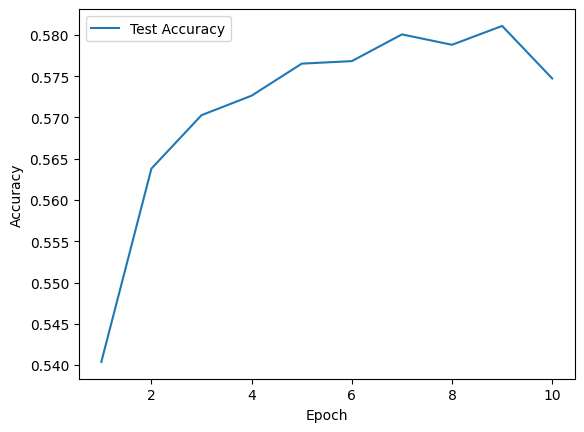

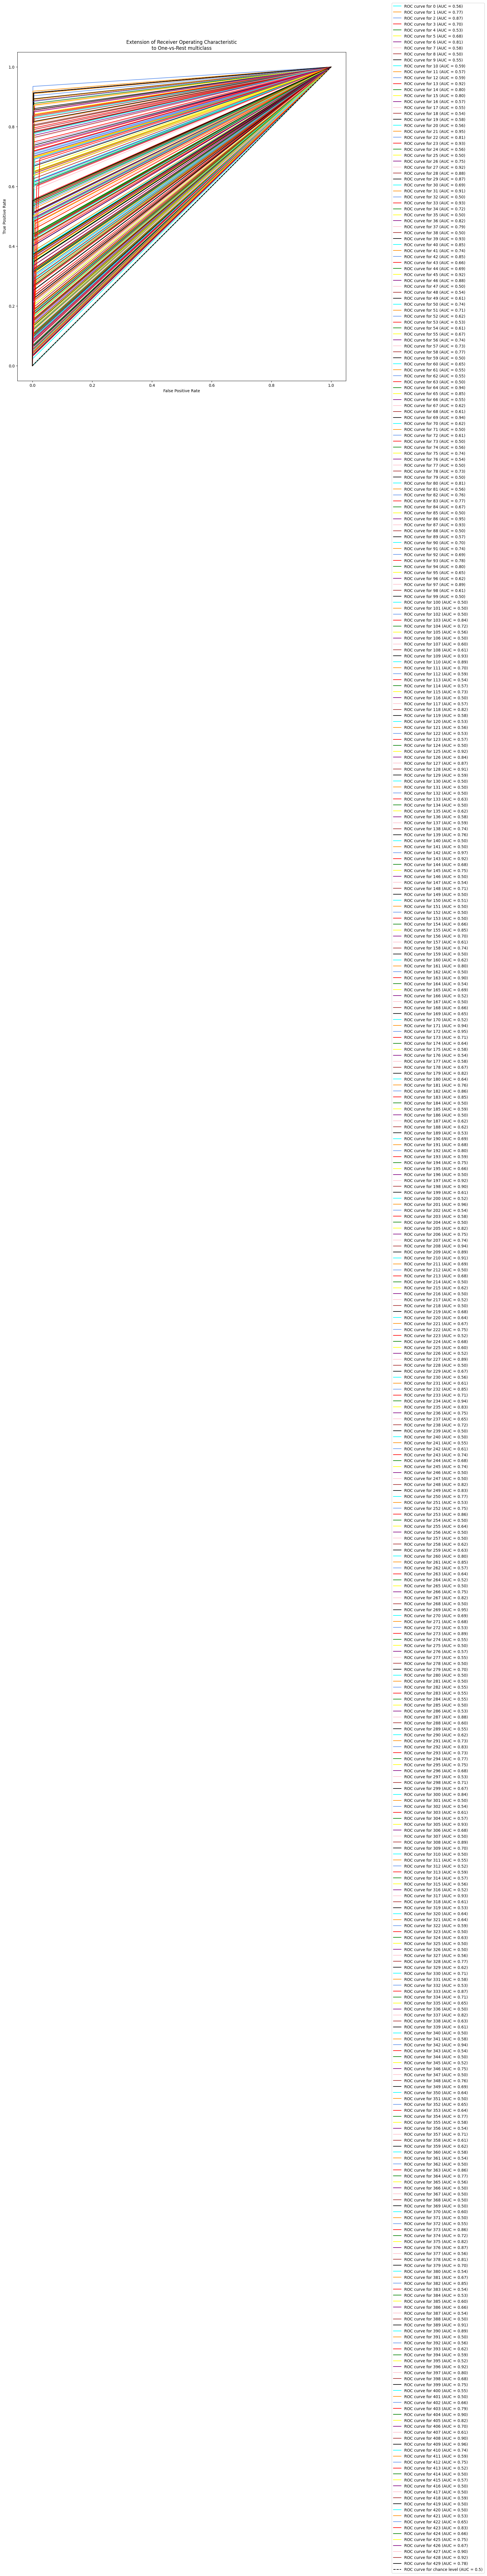

              precision    recall  f1-score   support

           0       0.16      0.12      0.14        41
           1       0.68      0.55      0.61       439
           2       0.75      0.74      0.74       163
           3       0.65      0.41      0.50        32
           4       0.25      0.07      0.11        15
           5       0.52      0.35      0.42        34
           6       0.68      0.61      0.64        31
           7       0.20      0.17      0.18        12
           8       0.00      0.00      0.00        10
           9       0.25      0.10      0.14        21
          10       0.40      0.18      0.25        11
          11       0.15      0.13      0.14        52
          12       0.24      0.17      0.20        29
          13       0.82      0.84      0.83       309
          14       0.64      0.60      0.62       116
          15       0.60      0.61      0.61        97
          16       0.17      0.14      0.15         7
          17       0.18    

In [9]:
# Train early fusion model
print("Training Early Fusion Model:")
train_early_fusion(train_loader, test_loader, text_input_size, image_input_size, output_size, num_epochs=10, multilabel=multilabel, report=True, set_weights=False, p=0.2)

Training Late Fusion Model:
The number of parameters of the model are: 367150
Epoch 1/10 - Test Accuracy: 0.5521
Epoch 1/10 - Training Time: 7.55 seconds | Inference Time: 4.54 seconds
Epoch 2/10 - Test Accuracy: 0.5744
Epoch 2/10 - Training Time: 7.08 seconds | Inference Time: 4.43 seconds
Epoch 3/10 - Test Accuracy: 0.5732
Epoch 3/10 - Training Time: 6.74 seconds | Inference Time: 4.33 seconds
Epoch 4/10 - Test Accuracy: 0.5886
Epoch 4/10 - Training Time: 7.13 seconds | Inference Time: 4.33 seconds
Epoch 5/10 - Test Accuracy: 0.5894
Epoch 5/10 - Training Time: 6.86 seconds | Inference Time: 4.44 seconds
Epoch 6/10 - Test Accuracy: 0.5880
Epoch 6/10 - Training Time: 7.00 seconds | Inference Time: 4.38 seconds
Epoch 7/10 - Test Accuracy: 0.5908
Epoch 7/10 - Training Time: 6.79 seconds | Inference Time: 4.45 seconds
Epoch 8/10 - Test Accuracy: 0.5956
Epoch 8/10 - Training Time: 7.86 seconds | Inference Time: 4.37 seconds
Epoch 9/10 - Test Accuracy: 0.5907
Epoch 9/10 - Training Time: 7.0

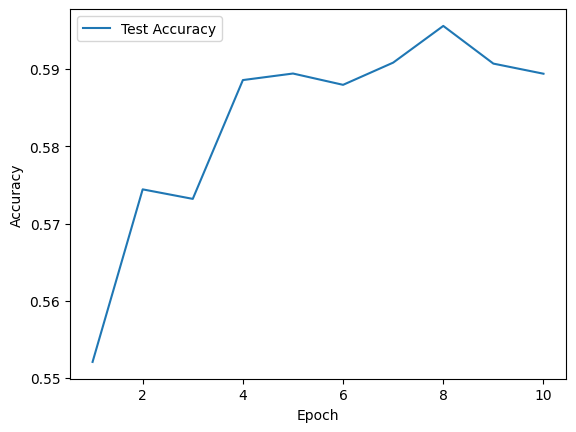

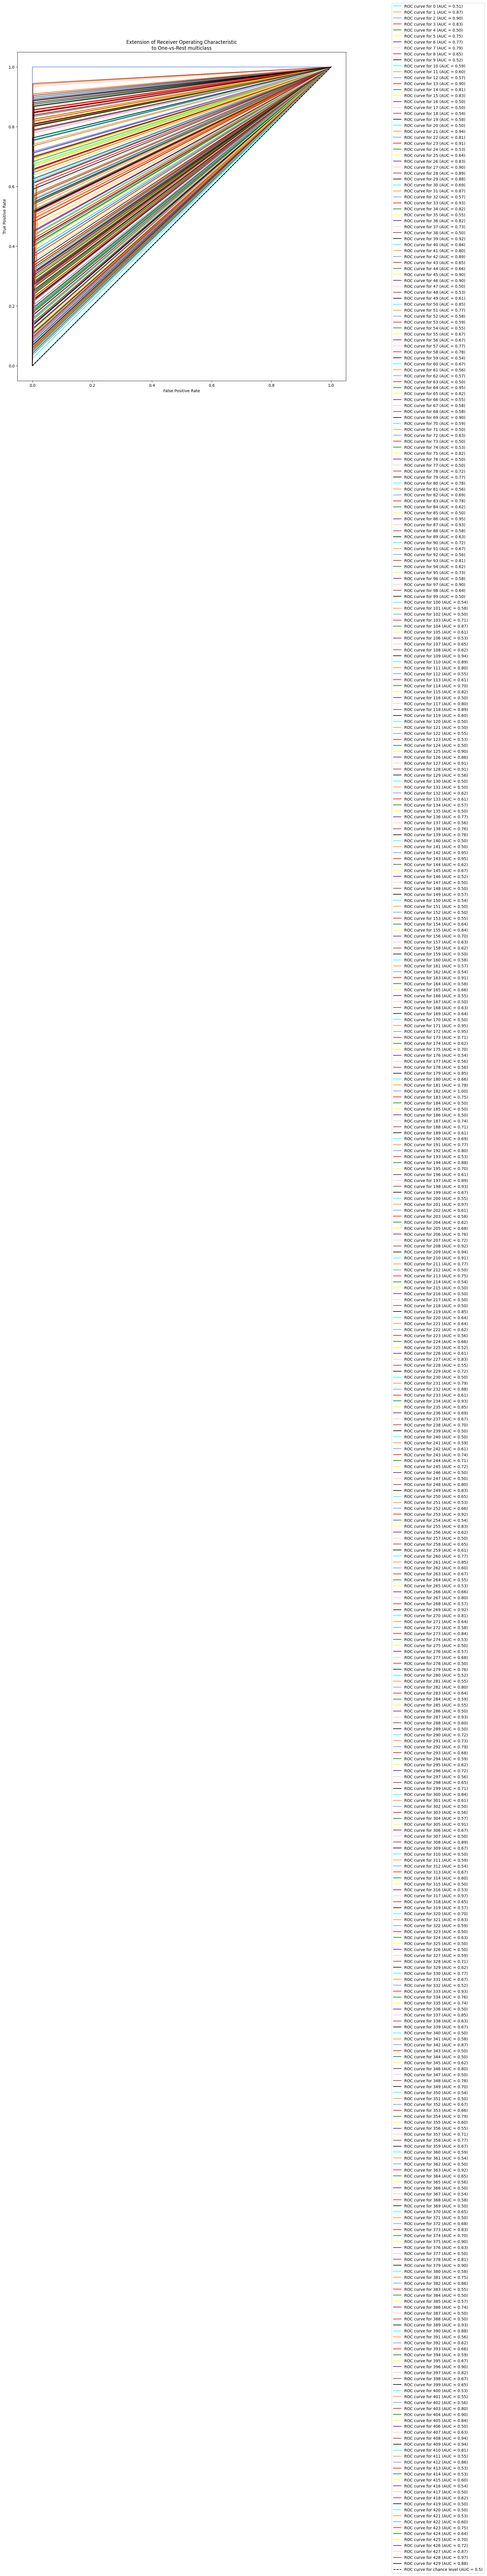

              precision    recall  f1-score   support

           0       0.50      0.02      0.05        41
           1       0.66      0.74      0.69       439
           2       0.71      0.81      0.75       163
           3       0.54      0.66      0.59        32
           4       0.00      0.00      0.00        15
           5       0.59      0.50      0.54        34
           6       0.71      0.55      0.62        31
           7       0.41      0.58      0.48        12
           8       0.38      0.30      0.33        10
           9       0.09      0.05      0.06        21
          10       0.22      0.18      0.20        11
          11       0.17      0.19      0.18        52
          12       0.44      0.14      0.21        29
          13       0.87      0.81      0.84       309
          14       0.70      0.61      0.65       116
          15       0.71      0.67      0.69        97
          16       0.00      0.00      0.00         7
          17       0.00    

In [10]:
# Train late fusion model
print("Training Late Fusion Model:")
train_late_fusion(train_loader, test_loader, text_input_size, image_input_size, output_size, num_epochs=10, multilabel=multilabel, report=True, set_weights=False, p=0.2)